# Complete ground by in-filling

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel)
import scipy
import scipy.ndimage
A = np.load('big_o_ground.npy')

C:\Users\patri\AppData\Local\Continuum\anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


C:\Users\patri\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


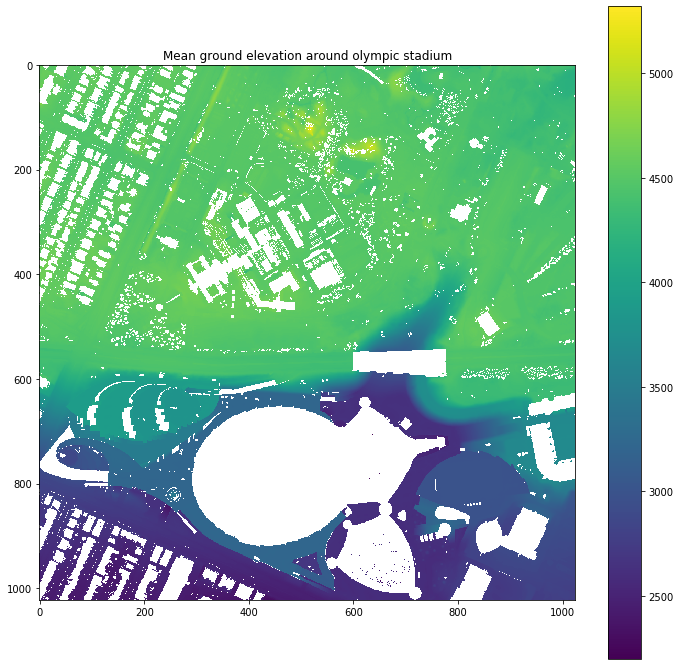

In [61]:
# Use a histogram to find areas without a ground plane
xrg = np.linspace(A[:, 0].min(), A[:, 0].max(), 1025)
yrg = np.linspace(A[:, 1].min(), A[:, 1].max(), 1025)

val_idx = A[:, 3] == 2

npoints, _, _ = np.histogram2d(A[val_idx, 0], A[val_idx, 1], [xrg, yrg])
total_height, gx, gy = np.histogram2d(A[val_idx, 0], A[val_idx, 1], [xrg, yrg], weights=A[val_idx, 2])

mean_height = total_height / npoints

plt.figure(figsize=(12, 12))
plt.imshow(mean_height)
plt.title("Mean ground elevation around olympic stadium")
plt.colorbar()

Do something simple - sample N points at random, fit a Gaussian process to interpolate, in-fill the data. More points = more precision. However, Gaussian processes are O(N^3), so this quickly hits a wall.

In [170]:
N_points = 1000
missing_data = npoints == 0

data = mean_height[~missing_data]
xgrid, ygrid = np.meshgrid(.5 * (xrg[:-1] + xrg[1:]), 
                           .5 * (yrg[:-1] + yrg[1:]))
xgrid_m, ygrid_m = xgrid[~missing_data], ygrid[~missing_data]

# Take N_points points at random, fit a Gaussian process. 
subs = np.random.permutation(np.arange(len(xgrid_m)))[:N_points]
gp_kernel = Matern(length_scale=0.001, length_scale_bounds=(1e-5, 1E-1), nu=1.5) + DotProduct(sigma_0=1000)
#    + WhiteKernel(1e-1)
gpr = GaussianProcessRegressor(kernel=gp_kernel, normalize_y=True)

X = np.concatenate((xgrid_m.reshape(-1, 1), ygrid_m.reshape(-1, 1)), axis=1)
gpr.fit(X[subs, :], data[subs])

C:\Users\patri\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([5438.53766103,   -7.45239258]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 100, 'nit': 24, 'warnflag': 2}
  ConvergenceWarning)


GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=Matern(length_scale=0.001, nu=1.5) + DotProduct(sigma_0=1e+03),
                         n_restarts_optimizer=0, normalize_y=True,
                         optimizer='fmin_l_bfgs_b', random_state=None)

In [171]:
gpr.kernel_

Matern(length_scale=0.000428, nu=1.5) + DotProduct(sigma_0=2.05e+03)

In [172]:
# We don't predict everything at once because that would take a lot of memory.
batch_size = 32
tile_size = len(xrg) - 1
nbatches = tile_size // batch_size

xgrid_c, ygrid_c = xgrid.ravel(), ygrid.ravel()
zs = []
for batch_num in range(nbatches):
    rg = slice(batch_num * tile_size * batch_size, (batch_num + 1) * tile_size * batch_size)
    X_ = np.concatenate((xgrid_c[rg].reshape(-1, 1), ygrid_c[rg].reshape(-1, 1)), axis=1)
    predicted_z = gpr.predict(X_)
    zs.append(predicted_z)

Text(0.5, 1.0, 'In-filled')

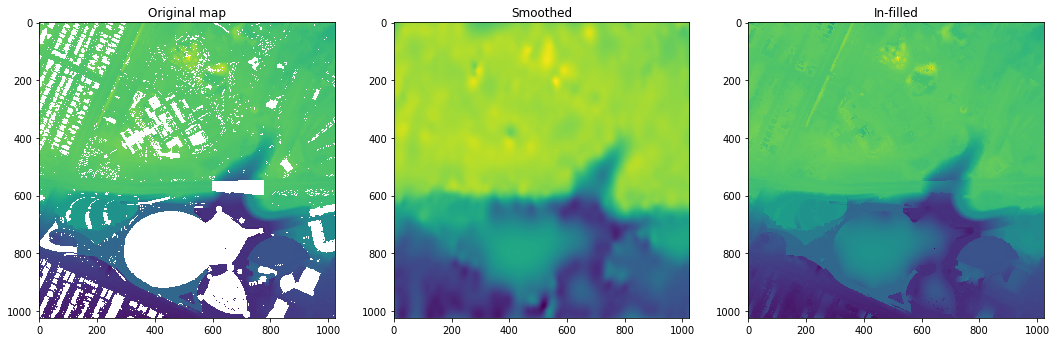

In [173]:
full_im = np.concatenate(zs).reshape((1024, 1024))
im = np.concatenate(zs).reshape((1024, 1024))
plt.figure(figsize=(18, 6))
plt.subplot(131)
plt.imshow(mean_height)
plt.title('Original map')
plt.subplot(132)
plt.imshow(full_im)
plt.title('Smoothed')
plt.subplot(133)
plt.imshow(np.where(np.isnan(mean_height), full_im, mean_height))
plt.title('In-filled')

This is pretty good, but you can see some artifacts - things don't line up 100% around the overpass north of the tower in the in-filled case. It would be better if the regression focuses on filling in around the unknown points.

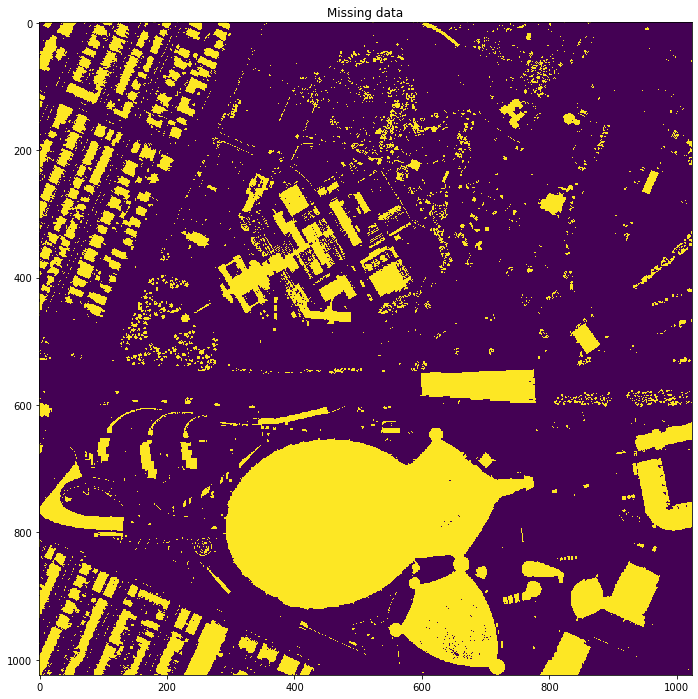

In [49]:
plt.figure(figsize=(12, 12))
plt.title('Missing data')
plt.imshow(npoints == 0)

232310

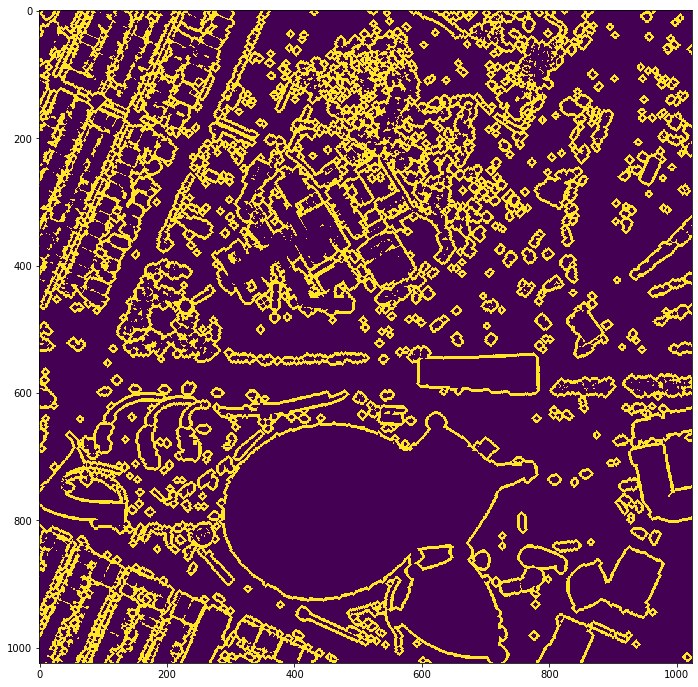

In [175]:
bad_data = npoints == 0

# Expand bad_data to reduce the number of distinct regions.
bad_data = scipy.ndimage.binary_dilation(bad_data, iterations=2)
bad_surround = bad_data ^ scipy.ndimage.binary_dilation(bad_data, iterations=5)

plt.figure(figsize=(12, 12))
plt.imshow(bad_surround)

#L, nregions = scipy.ndimage.label(bad_surround)
#nregions
bad_surround.sum()

Repeat the same idea, focusing on the elements of bad surround.

In [177]:
N_points = 1000
missing_data = bad_surround == 0

data = mean_height[~missing_data]
xgrid, ygrid = np.meshgrid(.5 * (xrg[:-1] + xrg[1:]), 
                           .5 * (yrg[:-1] + yrg[1:]))
xgrid_m, ygrid_m = xgrid[~missing_data], ygrid[~missing_data]

# Take N_points points at random, fit a Gaussian process. 
subs = np.random.permutation(np.arange(len(xgrid_m)))[:N_points]
gp_kernel = Matern(length_scale=0.001, length_scale_bounds=(1e-5, 1E-1), nu=1.5) + DotProduct(sigma_0=1000)
#    + WhiteKernel(1e-1)
gpr = GaussianProcessRegressor(kernel=gp_kernel, normalize_y=True)

X = np.concatenate((xgrid_m.reshape(-1, 1), ygrid_m.reshape(-1, 1)), axis=1)
gpr.fit(X[subs, :], data[subs])

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=Matern(length_scale=0.001, nu=1.5) + DotProduct(sigma_0=1e+03),
                         n_restarts_optimizer=0, normalize_y=True,
                         optimizer='fmin_l_bfgs_b', random_state=None)

In [181]:
# We don't predict everything at once because that would take a lot of memory.
batch_size = 32
tile_size = len(xrg) - 1
nbatches = tile_size // batch_size

xgrid_c, ygrid_c = xgrid.ravel(), ygrid.ravel()
zs = []
for batch_num in range(nbatches):
    rg = slice(batch_num * tile_size * batch_size, (batch_num + 1) * tile_size * batch_size)
    X_ = np.concatenate((xgrid_c[rg].reshape(-1, 1), ygrid_c[rg].reshape(-1, 1)), axis=1)
    predicted_z = gpr.predict(X_)
    zs.append(predicted_z)

Text(0.5, 1.0, 'In-filled')

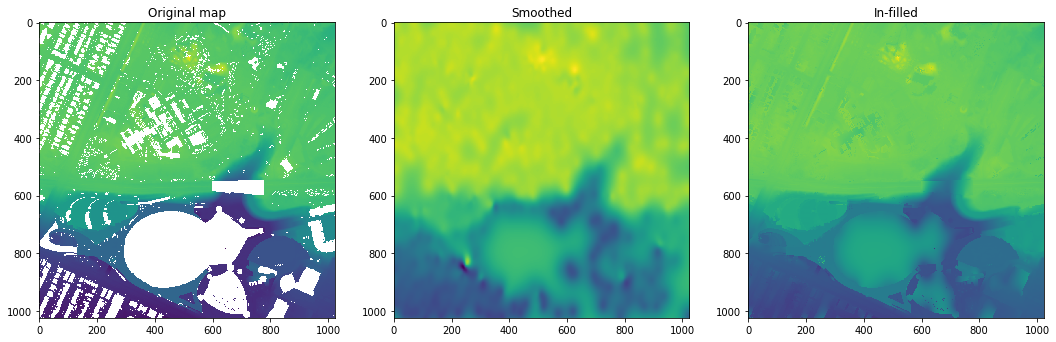

In [182]:
full_im = np.concatenate(zs).reshape((1024, 1024))
im = np.concatenate(zs).reshape((1024, 1024))
plt.figure(figsize=(18, 6))
plt.subplot(131)
plt.imshow(mean_height)
plt.title('Original map')
plt.subplot(132)
plt.imshow(full_im)
plt.title('Smoothed')
plt.subplot(133)
plt.imshow(np.where(np.isnan(mean_height), full_im, mean_height))
plt.title('In-filled')

Try a third way - in-painting via skimage.

Text(0.5, 1.0, 'In-painted via GPR')

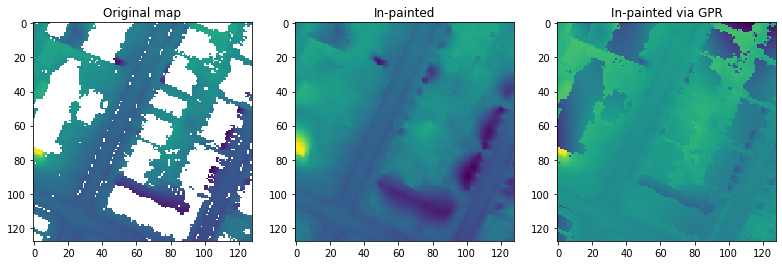

In [196]:
from skimage.restoration import inpaint
S = mean_height[:128, :128]
image_inpainted = inpaint.inpaint_biharmonic(S, np.isnan(S),
                                             multichannel=False)
plt.figure(figsize=(18, 6))
plt.subplot(141)
plt.imshow(mean_height[:S.shape[0], :S.shape[1]])
plt.title('Original map')
plt.subplot(142)
plt.imshow(image_inpainted)
plt.title('In-painted via skimage')
plt.subplot(143)
plt.imshow(np.where(np.isnan(mean_height), full_im, mean_height)[:S.shape[0], :S.shape[1]])
plt.title('In-painted via GPR')

In-painting via skimage does substantially better than via GPR- smoothing but especially around the edges underestimates heights - the "macro" looks ok but micro it's quite noisy. You can see, however, that there are a few badly estimated pixels which are far higher or lower than the mean right around houses and buildings (deep blue and deep yellow). We can try to zero these out to improve the reconstruction (it's quite subtle).

Text(0.5, 1.0, 'In-painted via GPR')

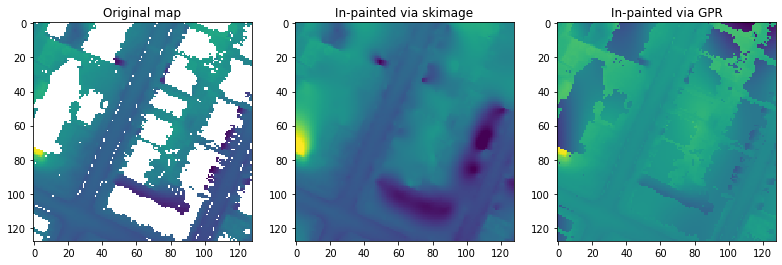

In [215]:
from skimage.restoration import inpaint
S = mean_height[:128, :128]
M = scipy.ndimage.binary_dilation(np.isnan(S), iterations=2)
image_inpainted = inpaint.inpaint_biharmonic(S, M,
                                             multichannel=False)
plt.figure(figsize=(18, 6))
plt.subplot(141)
plt.imshow(mean_height[:S.shape[0], :S.shape[1]])
plt.title('Original map')
plt.subplot(142)
plt.imshow(image_inpainted)
plt.title('In-painted via skimage')
plt.subplot(143)
plt.imshow(np.where(np.isnan(mean_height), full_im, mean_height)[:S.shape[0], :S.shape[1]])
plt.title('In-painted via GPR')

Inpainting takes quite a bit of memory, so do this in tiles.

In [216]:
S = mean_height[:512, :512]
M = scipy.ndimage.binary_dilation(np.isnan(S), iterations=2)
image_inpainted = inpaint.inpaint_biharmonic(S, M,
                                             multichannel=False)

Text(0.5, 1.0, 'In-painted via skimage')

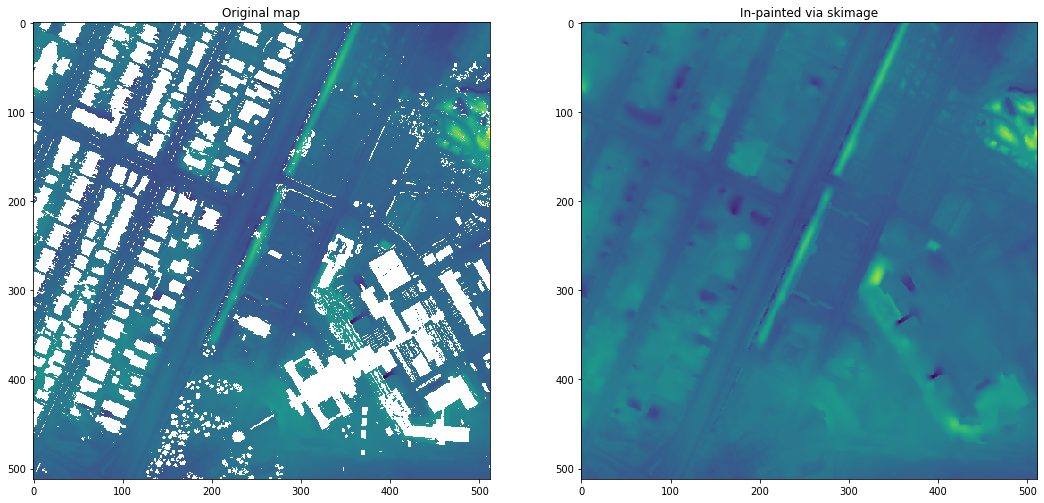

In [221]:
plt.figure(figsize=(18, 10))
plt.subplot(121)
plt.imshow(mean_height[:S.shape[0], :S.shape[1]])
plt.title('Original map')
plt.subplot(122)
plt.imshow(image_inpainted)
plt.title('In-painted via skimage')

C:\Users\patri\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


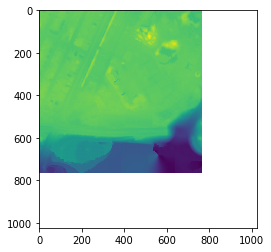

In [231]:
mean_height_infilled[mean_height_infilled == 0] = np.nan
plt.imshow(np.nanmean(mean_height_infilled, axis=2))

This works pretty well except for the stade. The stade takes up a significant portion of a tile, so it becomes impossible to infill with a smaller tile. Use GPR for this.

In [305]:
N_points = 1000
missing_data = npoints == 0

xgrid, ygrid = np.meshgrid(.5 * (xrg[:-1] + xrg[1:]), 
                           .5 * (yrg[:-1] + yrg[1:]))

bad_data = npoints == 0

# Expand bad_data to reduce the number of distinct regions.
I0 = mean_height.copy()
bad_regions, n_bad_regions = scipy.ndimage.label(scipy.ndimage.binary_dilation(np.isnan(mean_height), iterations=2))
surround = scipy.ndimage.grey_dilation(bad_regions, size=5)
counts, _ = np.histogram(bad_regions, np.arange(n_bad_regions + 1) - .5)

npixels = 1e4
N_points = 1000

for i in range(1, n_bad_regions):
    if counts[i] > npixels:
        # This is a big region, infill using the GPR method.
        surround_data = (surround == i) & (bad_regions == 0)
        xgrid_s, ygrid_s = xgrid[surround_data], ygrid[surround_data]
        
        # Take N_points points at random, fit a Gaussian process. 
        subs = np.random.permutation(np.arange(len(xgrid_s)))[:N_points]
        gp_kernel = Matern(length_scale=0.001, length_scale_bounds=(1e-5, 1E-1), nu=1.5)
        #    + WhiteKernel(1e-1)
        gpr = GaussianProcessRegressor(kernel=gp_kernel, normalize_y=True)

        X = np.concatenate((xgrid_s.reshape(-1, 1), ygrid_s.reshape(-1, 1)), axis=1)
        gpr.fit(X[subs, :], I0[surround_data][subs])
        xgrid_s, ygrid_s = xgrid[bad_regions == i], ygrid[bad_regions == i]
        X_ = np.concatenate((xgrid_s.reshape(-1, 1), ygrid_s.reshape(-1, 1)), axis=1)
        y_ = gpr.predict(X_)
        I0[bad_regions == i] = y_
        
#regions, nregions = bad_regions
#bad_surround = bad_data ^ scipy.ndimage.binary_dilation(bad_data, iterations=5)

In [268]:
gpr.kernel_

Matern(length_scale=5.06e-05, nu=1.5)

Text(0.5, 1.0, 'In-filled')

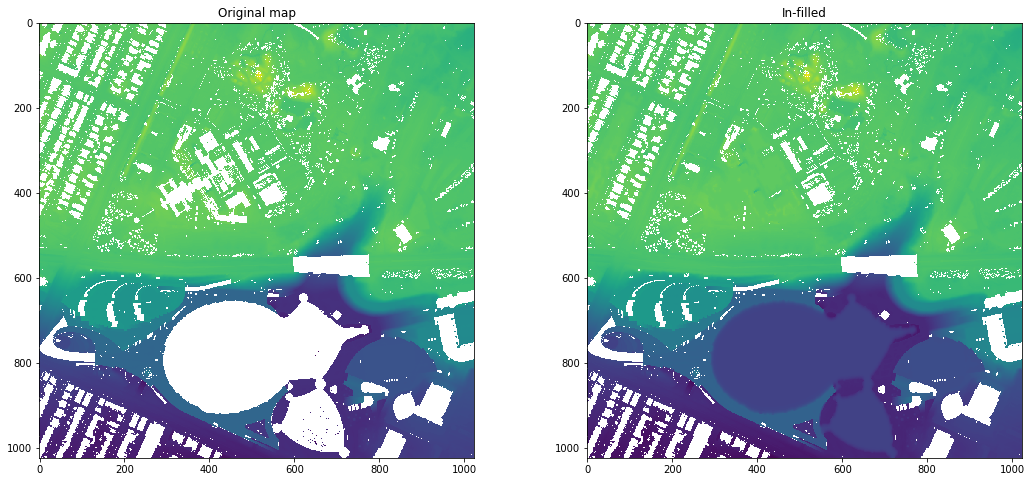

In [307]:
mask = scipy.ndimage.grey_erosion(np.isnan(mean_height), size = 5)
full_im = np.concatenate(zs).reshape((1024, 1024))
im = np.concatenate(zs).reshape((1024, 1024))
plt.figure(figsize=(18, 8))
plt.subplot(121)
plt.imshow(mean_height)
plt.title('Original map')
plt.subplot(122)
plt.imshow(I0)
plt.title('In-filled')

In [310]:
def infill_image(I):
    # Infill image via tiling.
    n_tiles = 4
    assert I.shape[0] == I.shape[1]
    tile_size = I.shape[0] // (n_tiles - 1)
    tile_delta = tile_size // 2
    
    k = 0
    I_stack = np.ones(I.shape + (2, 2)) * np.nan
    for j in range(n_tiles * 2 - 1):
        for i in range(n_tiles * 2 - 1):
            dy = slice(tile_delta * j, tile_delta * (j + 2))
            dx = slice(tile_delta * i, tile_delta * (i + 2))
            S = I[dy, dx]
            M = scipy.ndimage.binary_dilation(np.isnan(S), iterations=2)
            image_inpainted = inpaint.inpaint_biharmonic(S, M, multichannel=False)
            I_stack[dy, dx, j % 2, i % 2] = image_inpainted
            k += 1
    return np.nanmean(np.nanmean(mean_height_infilled, axis=2), axis=2)

mean_height_infilled = infill_image(I0)

C:\Users\patri\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice


Text(0.5, 1.0, 'Infilled height map around the stade')

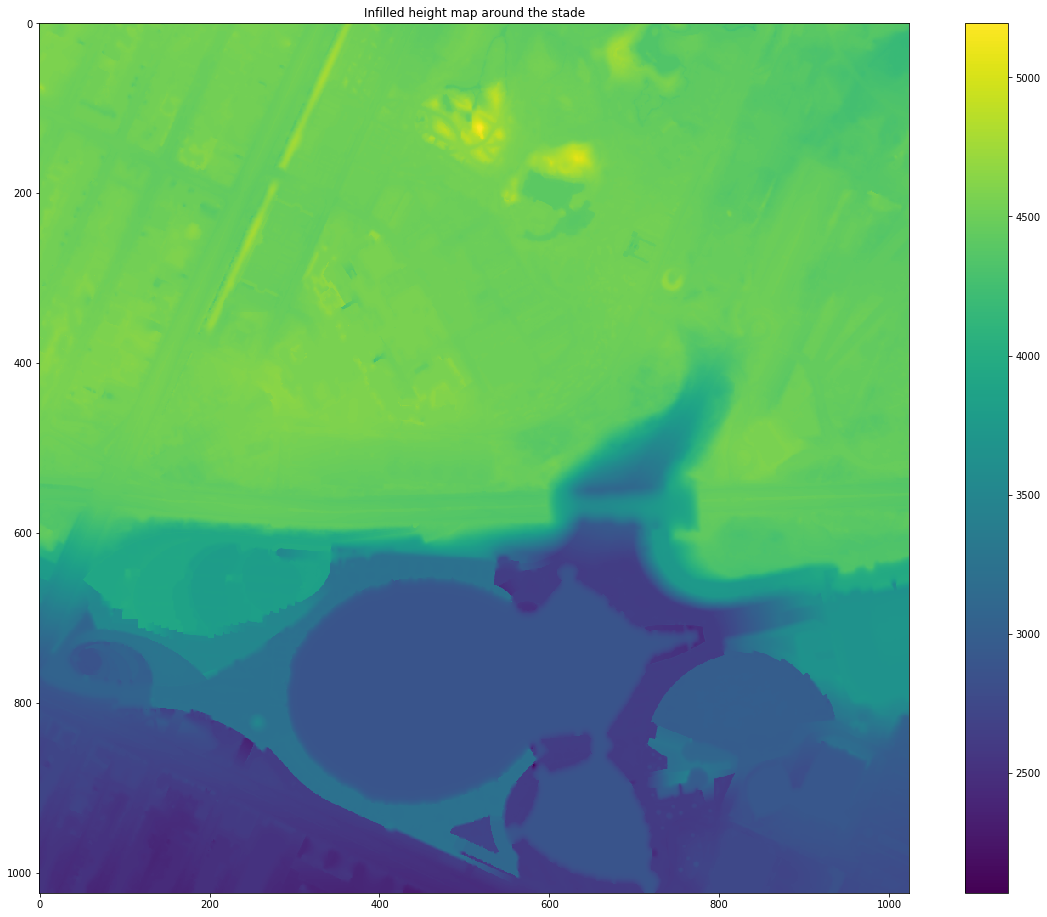

In [315]:
plt.figure(figsize=(20, 16))
plt.imshow(mean_height_infilled)
plt.colorbar()
plt.title('Infilled height map around the stade')